In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../src')
from data_utils import UnlearningDataLoader
from mufac_utils import MUFAC

/home/cspartalis/anaconda3/envs/MaUn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
UDL = UnlearningDataLoader("mufac", 128, 0)
dl, ds_sizes = UDL.load_data()
num_classes = len(UDL.classes)
input_channels = UDL.input_channels
image_size = UDL.image_size

In [3]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

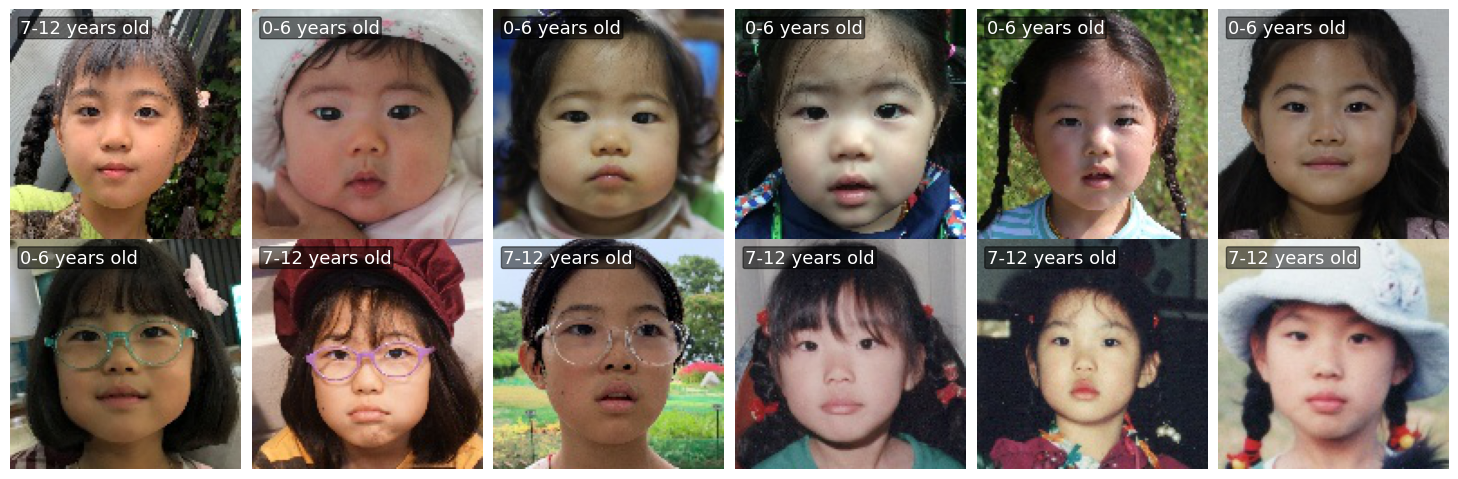

In [4]:
iterator = iter(dl["test"])
imgs, labels = next(iterator)

label_strs = [UDL.label_to_class[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

In [5]:
print("Samples per split:")
print("------------------")
print(f"Train--->{ds_sizes['train']}")
print(f"Test----->{ds_sizes['test']}")
print(f"Val------>{ds_sizes['val']}")
print(f"Forget--->{ds_sizes['forget']}")
print(f"Retain--->{ds_sizes['retain']}")
print("------------------")
print(f"Total--->{sum(ds_sizes.values())}")

Samples per split:
------------------
Train--->10025
Test----->1504
Val------>1539
Forget--->1500
Retain--->8525
------------------
Total--->23093


In [6]:
DATA_DIR = os.path.expanduser("~/data/")
df_train = pd.read_csv(os.path.join(DATA_DIR+"./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"))
df_val = pd.read_csv(os.path.join(DATA_DIR+"./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"))
df_test = pd.read_csv(os.path.join(DATA_DIR+"./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"))

df_forget = df_train[:1500]
df_retain = df_train[1500:]

In [7]:
df_train.columns

Index(['family_id', 'person_id', 'age_class', 'image_path'], dtype='object')

In [8]:
train_image_paths = df_train.image_path
val_image_paths = df_val.image_path
test_image_paths = df_test.image_path
forget_image_paths = df_forget.image_path
retain_image_paths = df_retain.image_path

train_val_overlap = len(set(train_image_paths) & set(val_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
val_forget_overlap = len(set(val_image_paths) & set(forget_image_paths))
val_retain_overlap = len(set(val_image_paths) & set(retain_image_paths))
val_test_overlap = len(set(val_image_paths) & set(test_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_test_overlap = len(set(forget_image_paths) & set(test_image_paths))
retain_test_overlap = len(set(retain_image_paths) & set(test_image_paths))

overlap_dict = {
    'train_val': train_val_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_test': train_test_overlap,
    'val_forget': val_forget_overlap,
    'val_retain': val_retain_overlap,
    'val_test': val_test_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_test': forget_test_overlap,
    'retain_test': retain_test_overlap
}

print("Overlapping samples between splits:")
overlap_dict



Overlapping samples between splits:


{'train_val': 0,
 'train_forget': 1500,
 'train_retain': 8525,
 'train_test': 0,
 'val_forget': 0,
 'val_retain': 0,
 'val_test': 0,
 'forget_retain': 0,
 'forget_test': 0,
 'retain_test': 0}

In [31]:
retain_labels = df_retain['age_class'].value_counts()
forget_labels = df_forget['age_class'].value_counts()
test_labels = df_test['age_class'].value_counts()
val_labels = df_val['age_class'].value_counts()

retain_labels = {UDL.label_to_class[UDL.idx_to_class[k]]: v for k, v in retain_labels.items()}
forget_labels = {UDL.label_to_class[UDL.idx_to_class[k]]: v for k, v in forget_labels.items()}
test_labels = {UDL.label_to_class[UDL.idx_to_class[k]]: v for k, v in test_labels.items()}
val_labels = {UDL.label_to_class[UDL.idx_to_class[k]]: v for k, v in val_labels.items()}


label_counts = [retain_labels, forget_labels, test_labels, val_labels]



In [29]:
retain_labels

age_class
a    1836
b    1713
c    1519
e    1229
d    1022
f     665
g     334
h     207
Name: count, dtype: int64

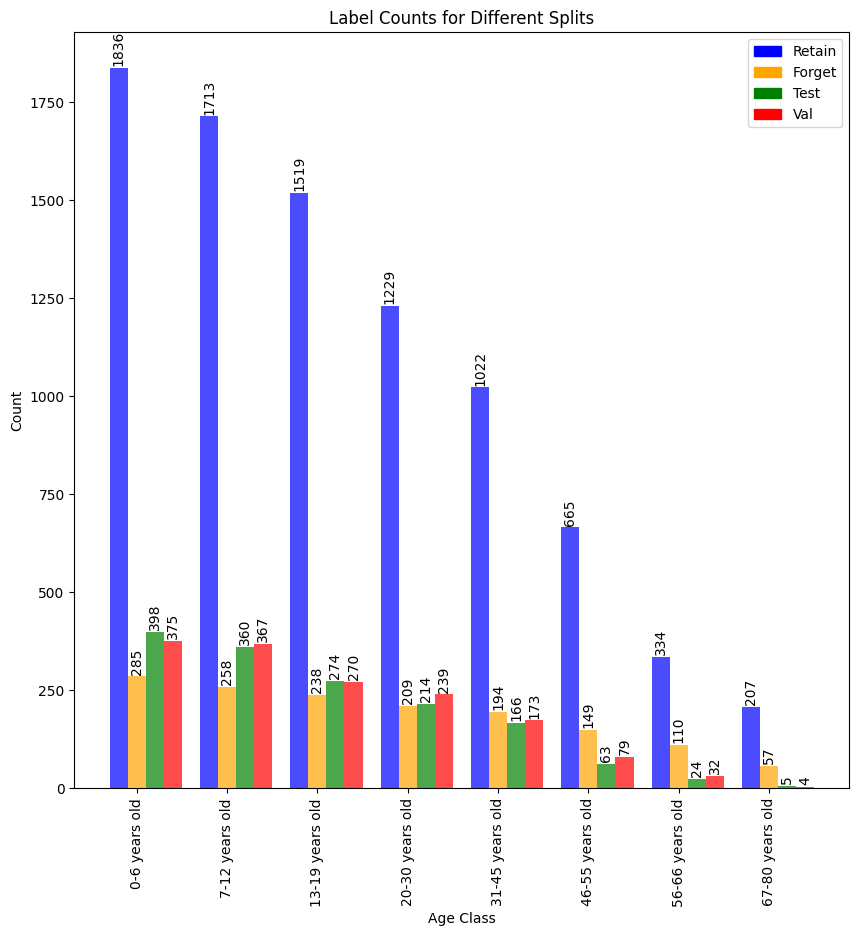

In [53]:
# Define the splits and their corresponding colors and labels
colors = ['blue', 'orange', 'green', 'red']
labels = ['Retain', 'Forget', 'Test', 'Val']

# Plot the label counts for each split
bar_width = 0.2
fig, ax = plt.subplots(figsize=(10, 4))
for i, (split, color, label) in enumerate(zip(label_counts, colors, labels)):
    x = [j + i * bar_width for j in range(len(split))]
    ax.bar(x, split.values(), color=color, alpha=0.7, width=bar_width, label=label)

    # Add value on top of each bar
    for j, value in enumerate(split.values()):
        ax.text(x[j], value + 5, str(value), ha='center', va='bottom', rotation=90)

# Add labels and legend
ax.set_xlabel('Age Class')
ax.set_ylabel('Count')
ax.set_title('Label Counts for Different Splits')
ax.set_xticks([j + bar_width for j in range(len(split))])
ax.set_xticklabels(split.keys(), rotation=90)  # Rotate xticks by 90 degrees

# Create custom legend
custom_legend = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(custom_legend, labels)

# Adjust the plot boundaries
plt.subplots_adjust(top=2)
# Show the plot
plt.show()
